<a id="im"></a>
# <center>IMPORTING LIBRARIES</center>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [4]:
train_dir = "data"
test_dir = "data"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 15
FINE_TUNING_EPOCHS = 10
LR = 0.01
NUM_CLASSES = 6
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [5]:
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

# preprocess_fun = tf.keras.applications.densenet.preprocess_input
preprocess_fun = to_grayscale_then_rgb

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 28275 images belonging to 6 classes.
Found 7065 images belonging to 6 classes.
Found 35340 images belonging to 6 classes.


## Data distribution (count) among differnt emotions

In [6]:
classLabelCounts = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)]
for classLabel, classLabelCount in zip(CLASS_LABELS, classLabelCounts):
  print(classLabel, classLabelCount)

Anger 3963
Fear 4097
Happy 7192
Neutral 4959
Sadness 4862
Surprise 3202


<a id="model"></a>
# <center> DenseNet169 Transfer Learning  </center>

In [7]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.05), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

## Summary of model

In [8]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               852480    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                             

<a id="train"></a>
# <center> Training and Fine-Tuning </center> 

## Training model with freezed layers of DenseNer169

In [9]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/15
  1/442 [..............................] - ETA: 1:32:26 - loss: 23.5982 - accuracy: 0.1094

2023-09-06 20:29:55.281218: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25214976 exceeds 10% of free system memory.
2023-09-06 20:29:55.281340: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25214976 exceeds 10% of free system memory.
2023-09-06 20:29:55.309806: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25214976 exceeds 10% of free system memory.
2023-09-06 20:29:55.309925: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25214976 exceeds 10% of free system memory.
2023-09-06 20:29:55.336785: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25214976 exceeds 10% of free system memory.


442/442 [==============================] - 294s 638ms/step - loss: 15.9689 - accuracy: 0.3053 - val_loss: 10.3008 - val_accuracy: 0.4500
Epoch 2/15
442/442 [==============================] - 386s 874ms/step - loss: 7.2345 - accuracy: 0.4852 - val_loss: 5.0874 - val_accuracy: 0.4831
Epoch 3/15
442/442 [==============================] - 362s 820ms/step - loss: 3.6568 - accuracy: 0.5438 - val_loss: 2.7895 - val_accuracy: 0.5231
Epoch 4/15
442/442 [==============================] - 296s 669ms/step - loss: 2.1595 - accuracy: 0.5799 - val_loss: 1.9451 - val_accuracy: 0.5200
Epoch 5/15
442/442 [==============================] - 294s 665ms/step - loss: 1.5150 - accuracy: 0.6061 - val_loss: 1.3968 - val_accuracy: 0.5850
Epoch 6/15
442/442 [==============================] - 290s 657ms/step - loss: 1.2320 - accuracy: 0.6200 - val_loss: 1.2394 - val_accuracy: 0.5965
Epoch 7/15
442/442 [==============================] - 291s 659ms/step - loss: 1.1008 - accuracy: 0.6352 - val_loss: 1.1630 - val_accu

## Fine Tuning

In [10]:
# Un-Freezing the feature extraction layers for fine tuning
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)

Epoch 1/10
442/442 [==============================] - 329s 713ms/step - loss: 0.8103 - accuracy: 0.7297 - val_loss: 0.9781 - val_accuracy: 0.6692
Epoch 2/10
442/442 [==============================] - 324s 732ms/step - loss: 0.7805 - accuracy: 0.7375 - val_loss: 0.9725 - val_accuracy: 0.6752
Epoch 3/10
442/442 [==============================] - 335s 757ms/step - loss: 0.7627 - accuracy: 0.7425 - val_loss: 0.9715 - val_accuracy: 0.6787
Epoch 4/10
442/442 [==============================] - 343s 776ms/step - loss: 0.7512 - accuracy: 0.7496 - val_loss: 0.9719 - val_accuracy: 0.6797
Epoch 5/10
442/442 [==============================] - 347s 785ms/step - loss: 0.7358 - accuracy: 0.7530 - val_loss: 0.9739 - val_accuracy: 0.6793
Epoch 6/10
442/442 [==============================] - 348s 787ms/step - loss: 0.7321 - accuracy: 0.7552 - val_loss: 0.9713 - val_accuracy: 0.6786
Epoch 7/10
442/442 [==============================] - 353s 800ms/step - loss: 0.7195 - accuracy: 0.7627 - val_loss: 0.9751 -

In [11]:
history = history._append(pd.DataFrame(history_.history) , ignore_index=True)

## Model Evaluation

In [12]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

553/553 [==============================] - 102s 181ms/step


## Confusion Matrix

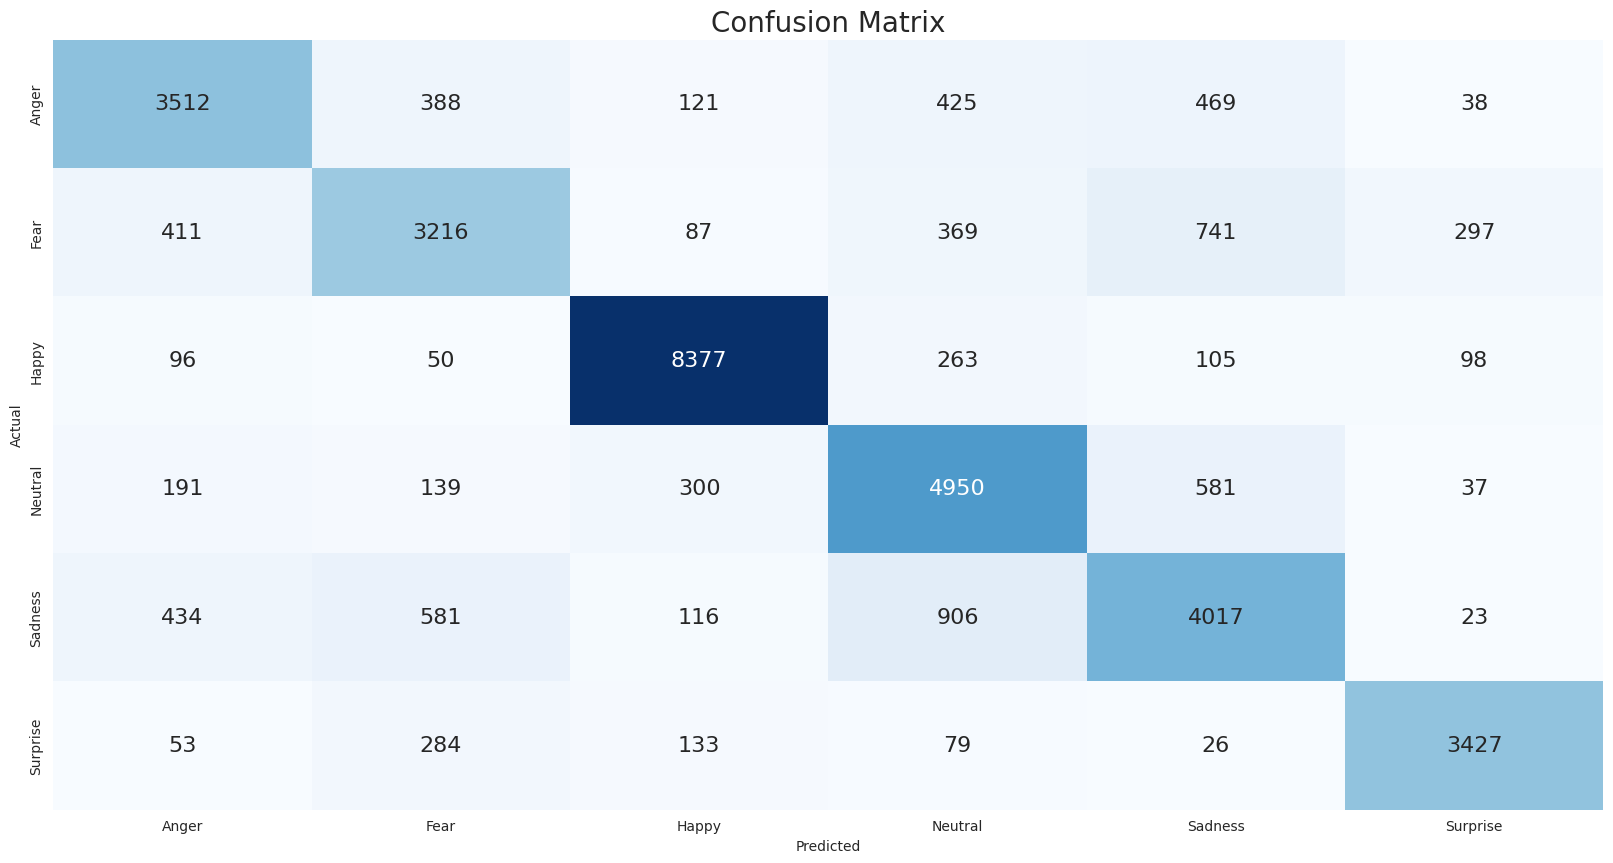

In [13]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [14]:
model.save('../cfg/model.h5')

In [15]:
# ! pip install -q kaggle
# from google.colab import files
#
# files.upload()
# ! mkdir ~/.kaggle
#
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

In [16]:
# ! kaggle datasets download -d ananthu017/emotion-detection-fer

In [17]:
# import zipfile
# import os
#
# data_r = zipfile.ZipFile('/content/emotion-detection-fer.zip', 'r')
# data_r.extractall()

In [18]:
# import shutil, sys
# shutil.rmtree('/content/test/disgusted')

In [19]:
model.save('../cfg/model_new.h5')